In [ ]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.hux import HUX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.optimize import minimize
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from utils import *
display_pca = False
N_NEIGHBOURS = 5

ImportError: cannot import name 'InitialSampling' from 'pymoo.core.initialization' (c:\Users\RjKim\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymoo\core\initialization.py)

# Overall function definitions

In [ ]:
class InstanceSelectionProblem_2_Obj(Problem):
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=2,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		# Calculate number of examples in each instance
		f1 = np.sum(x, axis=1)

		# Calculate inverse accuracy
		f2 = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)

		out["F"] = np.column_stack([f1, f2])

	def train_model(self, instance):
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= N_NEIGHBOURS:
			optimization_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			y_pred = optimization_knn.predict(self.X_val)
			acc = accuracy_score(self.y_val, y_pred)
			return 1-acc
		else:
			return 1

class InstanceSelectionProblem_3_Obj(Problem):
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=3,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):
		# Calculate number of examples in each instance
		f1 = np.sum(x, axis=1)

		# Calculate inverse accuracy
		f2 = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)

		f3 = Parallel(n_jobs=-1)(delayed(self.calculate_instance_IR)(instance) for instance in x)
		
		out["F"] = np.column_stack([f1, f2, f3])

	def calculate_instance_IR(self, instance):
		num_1_class = np.sum(self.y_train[instance])
		num_0_class = self.n_instances - num_1_class
		IR = max(num_0_class, num_1_class) / min(num_0_class, num_1_class)
		return IR

	def train_model(self, instance):
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= N_NEIGHBOURS:
			optimization_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			y_pred = optimization_knn.predict(self.X_val)
			acc = accuracy_score(self.y_val, y_pred)
			return 1-acc
		else:
			return 1

class InstanceSelectionProblem_2_Obj_MinMajAcc(Problem):
	def __init__(self, X_train, y_train, X_val, y_val):
		
		self.X_train = X_train
		self.y_train = y_train

		self.X_val = X_val
		self.y_val = y_val

		self.training_data = X_train
		self.n_instances = X_train.shape[0]
		
		super().__init__(
			n_var=self.n_instances,
			n_obj=2,               
			n_constr=0,            
			xl=0,                  
			xu=1,                  
			type_var=np.bool_,     
		)

	def _evaluate(self, x, out, *args, **kwargs):

		# Calculate inverse accuracy of both classes seperately
		objectives = Parallel(n_jobs=-1)(delayed(self.train_model)(instance) for instance in x)

		out["F"] = np.column_stack(objectives)

	def train_model(self, instance):
		x_train_filtered, y_train_filtered = self.X_train[instance], self.y_train[instance]
		
		num_included_instances = x_train_filtered.shape[0]

		if num_included_instances >= N_NEIGHBOURS:
			optimization_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
			optimization_knn.fit(x_train_filtered, y_train_filtered)

			class_1_indices = np.where(self.y_val==1)
			class_0_indices = np.where(self.y_val==0)

			class_1_x_val = self.X_val[class_1_indices]
			class_0_x_val = self.X_val[class_0_indices]

			class_1_y_val = self.y_val[class_1_indices]
			class_0_y_val = self.y_val[class_0_indices]
			
			class_1_pred = optimization_knn.predict(class_1_x_val)
			class_1_acc = accuracy_score(class_1_y_val, class_1_pred)

			class_0_pred = optimization_knn.predict(class_0_x_val)
			class_0_acc = accuracy_score(class_0_y_val, class_0_pred)

			return [1-class_1_acc, 1-class_0_acc]
		else:
			return [1, 1]
				
def parse_dataset(path, name, over_sample=False):
	try:
		df = pd.read_csv(path, delimiter=', ')
		X = df.drop(columns='Class')
		y = df['Class']
	except KeyError:
		df = pd.read_csv(path, delimiter=',')
		X = df.drop(columns='Class')
		y = df['Class']

	# Generate train, validation, and test sets
	label_encoder = LabelEncoder()
	y_encoded = label_encoder.fit_transform(y)
	X_train, X_val, X_test, y_train, y_val, y_test = split_and_scale_datasets(X, y_encoded)

	if over_sample:
		class_0_count, class_1_count, IR = set_summary(y_train, "y_train", False)
		if class_0_count > class_1_count:
			minority_class_indicies = np.where(y_train == 1)
		else:
			minority_class_indicies = np.where(y_train == 0)

		X_train = np.concatenate((X_train, X_train[minority_class_indicies]), axis=0)
		y_train = np.concatenate((y_train, y_train[minority_class_indicies]), axis=0)

	return [X, y, X_train, X_val, X_test, y_train, y_val, y_test, name]

def class_based_accuracy(model, x, y):
	class_1_indices = np.where(y==1)
	class_0_indices = np.where(y==0)

	class_1_x = x[class_1_indices]
	class_0_x = x[class_0_indices]

	class_1_y = y[class_1_indices]
	class_0_y = y[class_0_indices]
	
	class_1_pred = model.predict(class_1_x)
	class_1_acc = accuracy_score(class_1_y, class_1_pred)

	class_0_pred = model.predict(class_0_x)
	class_0_acc = accuracy_score(class_0_y, class_0_pred)

	overall_prediction = model.predict(x)
	overall_accuracy = accuracy_score(y, overall_prediction)

	return class_1_acc, class_0_acc, overall_accuracy

NameError: name 'InitialSampling' is not defined

# Defining and packaging datasets

In [4]:
datasets = []
for folder in os.listdir('Datasets'):
	datasets.append(parse_dataset(os.path.join('Datasets', folder, f"{folder}.csv"), folder, over_sample=True))

C:\Users\RjKim\AppData\Local\Temp\ipykernel_8096\604476371.py:157: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, delimiter=', ')
C:\Users\RjKim\AppData\Local\Temp\ipykernel_8096\604476371.py:157: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, delimiter=', ')
C:\Users\RjKim\AppData\Local\Temp\ipykernel_8096\604476371.py:157: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [32]:
def execute_class_sensitive_optimization(X, y, X_train, X_val, X_test, y_train, y_val, y_test, name, problem_defn):
	print(f"Executing {problem_defn} on {name}...")

	num_examples, num_features = set_summary(X, 'x', print_res=False)
	class_0_count, class_1_count, baseline_IR = set_summary(y, 'y', print_res=False)
	minority = min(class_0_count, class_1_count)
	minority_class = 0 if minority == class_0_count else 1

	# Determine baseline accuracy of classifier on all examples
	baseline_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
	baseline_knn.fit(X_train, y_train)
	class_1_baseline_acc, class_0_baseline_acc, overall_baseline_acc = class_based_accuracy(baseline_knn, X_test, y_test)
	
	# Execute the optimization algorithm
	algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
	problem = problem_defn(X_train, y_train, X_val, y_val)
	res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

	# Calculate the first rank pareto front
	fronts = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
	unique_F, unique_indices = np.unique(res.F[fronts], axis=0, return_index=True)

	# Extract best instances for minimization of f1 error
	best_instance_idx = np.argmin(unique_F[:,0])
	best_instance = res.X[unique_indices[best_instance_idx]]
	
	# Calculate the optimized accuracy of the best instance
	x_train_filtered, y_train_filtered = X_train[best_instance], y_train[best_instance]
	num_instance_in_best_solution = y_train_filtered.shape[0]
	_, _, optimized_IR = set_summary(y_train_filtered, 'y', print_res=False)
	optimized_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
	optimized_knn.fit(x_train_filtered, y_train_filtered)
	class_1_optimized_acc, class_0_optimized_acc, overall_acc = class_based_accuracy(optimized_knn, X_test, y_test)


	x1, y1 = [row[0] for row in unique_F], [row[1] for row in unique_F]
	plt.ylim((0, 1))
	plt.xlim((0, 1))
	plt.ylabel("f1")
	plt.xlabel("f2")
	plt.scatter(x1, y1, c='b')
	plt.show()

	return[name, 
		   num_features, 
		   num_examples,
		   X_train.shape[0],
		   num_instance_in_best_solution,
		   minority_class,
		   round(class_1_baseline_acc*100,2), 
		   round(class_0_baseline_acc*100,2), 
		   round(overall_baseline_acc*100,2), 
		   round(class_1_optimized_acc*100,2), 
		   round(class_0_optimized_acc*100,2), 
		   round(overall_acc*100,2), 
		   baseline_IR,
		   optimized_IR]

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMajAcc'> on ClassAccs-glass1...


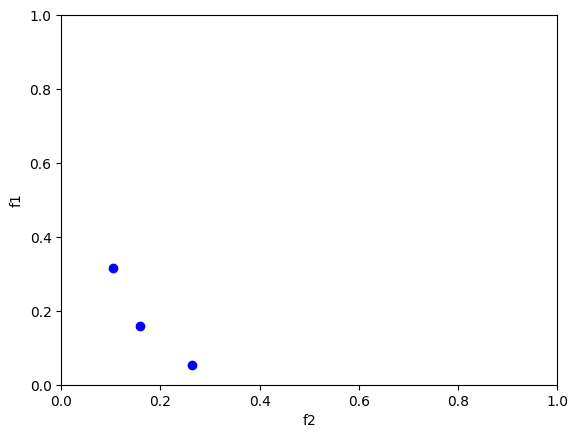

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMajAcc'> on ClassAccs-page-blocks0...


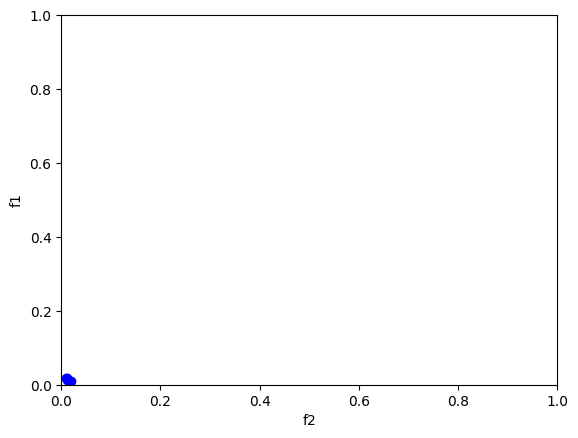

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMajAcc'> on ClassAccs-pima...


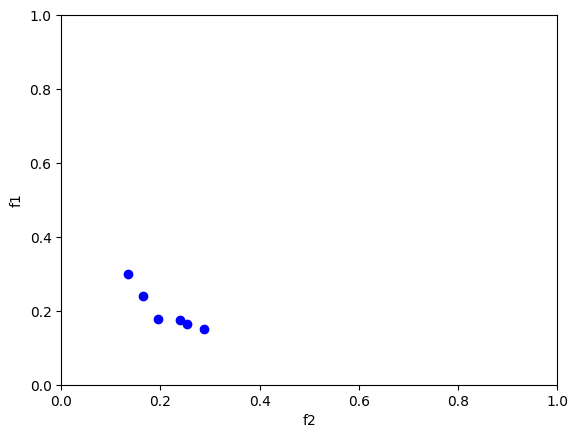

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMajAcc'> on ClassAccs-segment0...


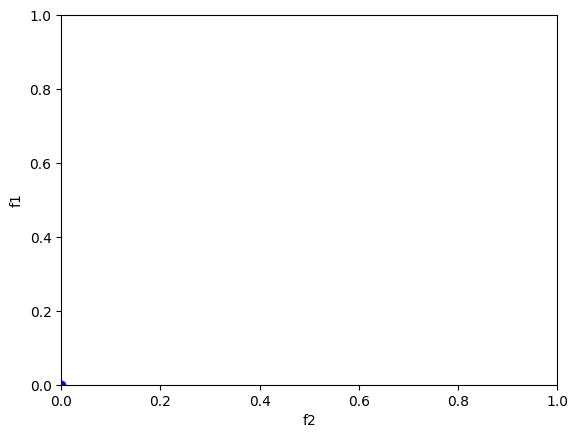

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMajAcc'> on ClassAccs-vehicle0...


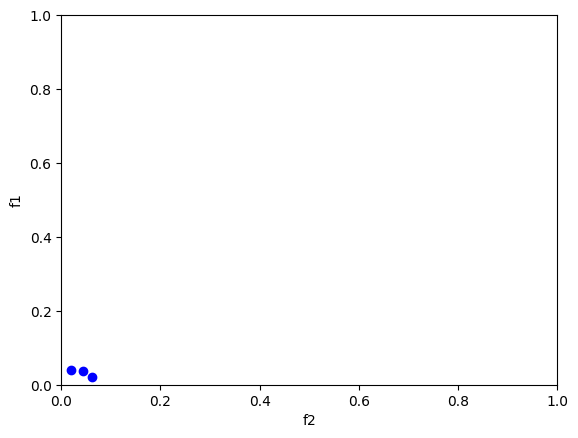

Executing <class '__main__.InstanceSelectionProblem_2_Obj_MinMajAcc'> on ClassAccs-yeast1...


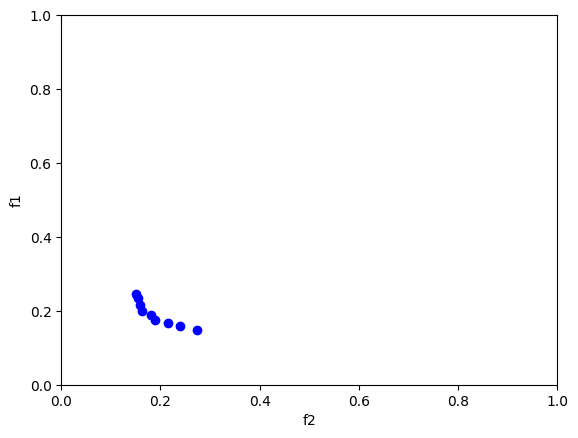

In [33]:
report_columns = ["Dataset",  "# Feature", "# Example", "# Training Examples", "Optimized # Examples", "Minority Class", "Baseline Acc % C1", "Baseline Acc % C0", "Baseline Acc % Overall", "Optimized Acc % C1", "Optimized Acc % C0", "Optimized Acc % Overall", "IR of entire dataset", "Best solution IR"]
results = []
for X, y, X_train, X_val, X_test, y_train, y_val, y_test, name in datasets:
	result = execute_class_sensitive_optimization(X, y, X_train, X_val, X_test, y_train, y_val, y_test, f"ClassAccs-{name}", InstanceSelectionProblem_2_Obj_MinMajAcc)
	results.append(result)

In [34]:
pd.DataFrame(results, columns=report_columns)

,Dataset,# Feature,# Example,# Training Examples,Optimized # Examples,Minority Class,Baseline Acc % C1,Baseline Acc % C0,Baseline Acc % Overall,Optimized Acc % C1,Optimized Acc % C0,Optimized Acc % Overall,IR of entire dataset,Best solution IR
0,ClassAccs-glass1,9,214,145,85,1,68.42,71.43,70.37,73.68,68.57,70.37,1.8158,1.1795
1,ClassAccs-page-blocks0,10,5472,3016,1497,1,87.05,98.05,96.93,82.73,98.13,96.56,8.7889,4.3849
2,ClassAccs-pima,8,768,518,254,1,62.69,73.60,69.79,76.12,60.80,66.15,1.8657,1.3519
3,ClassAccs-segment0,19,2308,1319,656,1,98.78,98.59,98.61,98.78,97.98,98.09,6.0152,2.9518
4,ClassAccs-vehicle0,18,846,523,264,1,92.00,93.21,92.92,94.00,89.51,90.57,3.2513,1.6667
5,ClassAccs-yeast1,8,1484,957,474,1,64.49,76.14,72.78,68.22,71.21,70.35,2.4592,1.2150


In [11]:
def execute(X, y, X_train, X_val, X_test, y_train, y_val, y_test, name, problem_defn):
	print(f"Executing {problem_defn} on {name}...")

	num_examples, num_features = set_summary(X, 'x', print_res=False)
	_, _, baseline_IR = set_summary(y, 'y', print_res=False)

	# Determine baseline accuracy of classifier on all examples
	baseline_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
	baseline_knn.fit(X_train, y_train)
	y_pred = baseline_knn.predict(X_test)
	baseline_test_acc = accuracy_score(y_test, y_pred)
	
	# Execute the optimization algorithm
	algorithm = NSGA2(pop_size=100, sampling=BinaryRandomSampling(), crossover=HUX(), mutation=BitflipMutation(), eliminate_duplicates=True)
	problem = problem_defn(X_train, y_train, X_val, y_val)
	res = minimize(problem, algorithm, ('n_gen', 100), verbose=False, seed=42)

	# Calculate the best instance and extract its values
	test_pareto_front = []
	fronts = NonDominatedSorting().do(res.F, only_non_dominated_front=True)
	unique_F, unique_indices = np.unique(res.F[fronts], axis=0, return_index=True)
	best_instance_idx = np.argmin(unique_F[:,1])
	num_instance_in_best_solution = unique_F[best_instance_idx, 0]
	best_instance = res.X[unique_indices[best_instance_idx]]
	
	# Calculate the optimized accuracy of the best instance
	x_train_filtered, y_train_filtered = X_train[best_instance], y_train[best_instance]
	_, _, optimized_IR = set_summary(y_train_filtered, 'y', print_res=False)
	optimized_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
	optimized_knn.fit(x_train_filtered, y_train_filtered)
	y_pred = optimized_knn.predict(X_test)
	optimzed_test_acc = accuracy_score(y_test, y_pred)

	for instance in res.X[unique_indices]:
		x_filtered, y_filtered = X_train[instance], y_train[instance]
		if x_filtered.shape[0] < N_NEIGHBOURS: acc = 1
		else:
			knn = KNeighborsClassifier(n_neighbors=N_NEIGHBOURS)
			knn.fit(x_filtered, y_filtered)
			y_pred = knn.predict(X_test)
			acc = 1 - accuracy_score(y_test, y_pred)
		test_pareto_front.append([x_filtered.shape[0], acc])
	x2, y2 = [row[0] for row in test_pareto_front], [row[1] for row in test_pareto_front]

	x1, y1 = [row[0] for row in unique_F], [row[1] for row in unique_F]
	plt.ylim((0, 1))
	plt.ylabel("f1")
	plt.xlabel("f2")
	plt.scatter(x1, y1, c='b')
	plt.scatter(x2, y2, c='r')
	plt.show()

	return[name, 
		   num_features, 
		   num_examples,
		   X_train.shape[0],
		   num_instance_in_best_solution,
		   round(baseline_test_acc*100,2), 
		   round(optimzed_test_acc*100,2), 
		   baseline_IR,
		   optimized_IR]

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on 2Obj-glass1...


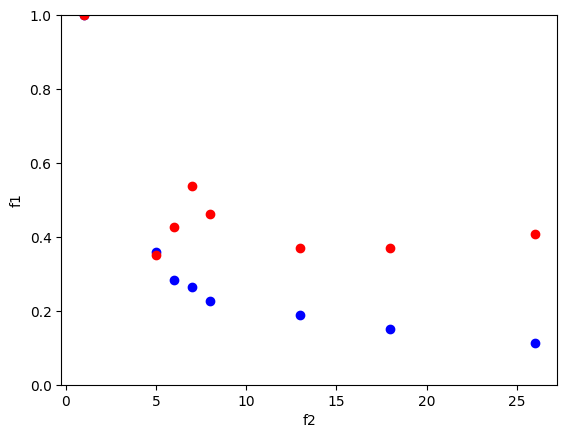

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on 3Obj-glass1...


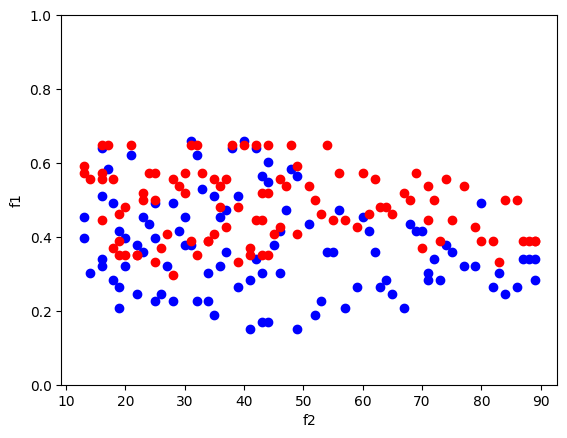

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on 2Obj-page-blocks0...


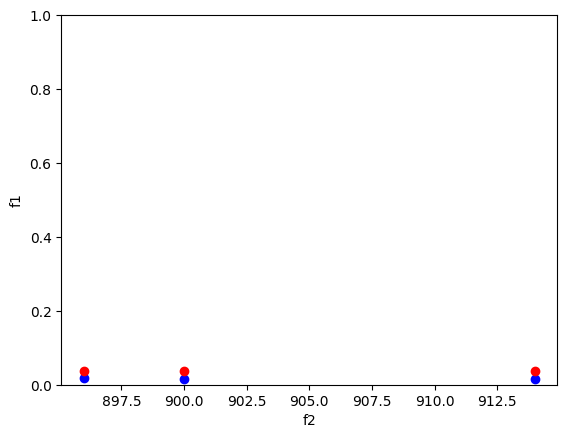

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on 3Obj-page-blocks0...


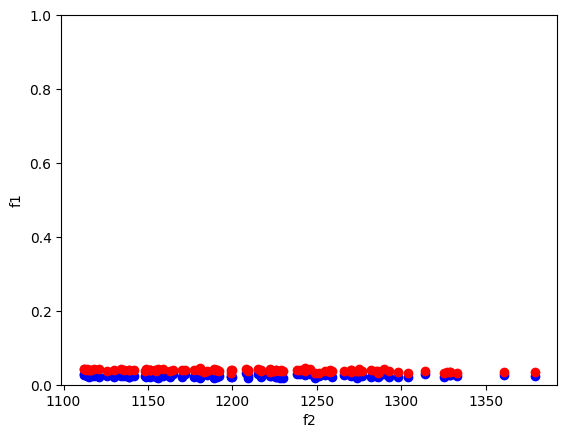

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on 2Obj-pima...


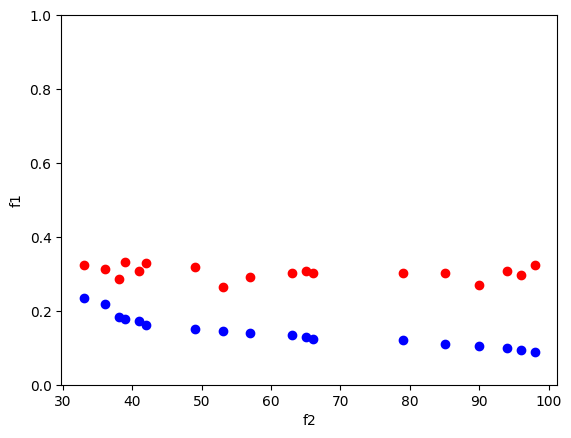

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on 3Obj-pima...


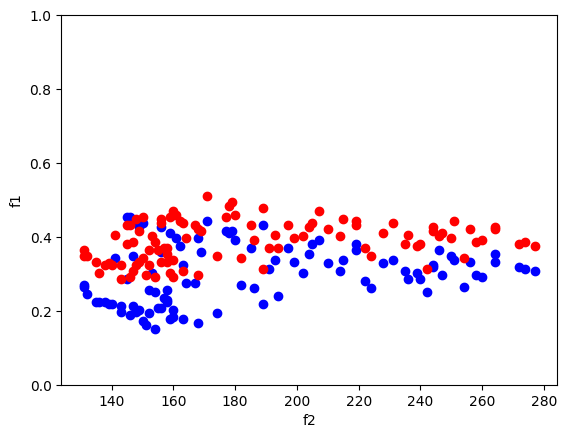

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on 2Obj-segment0...


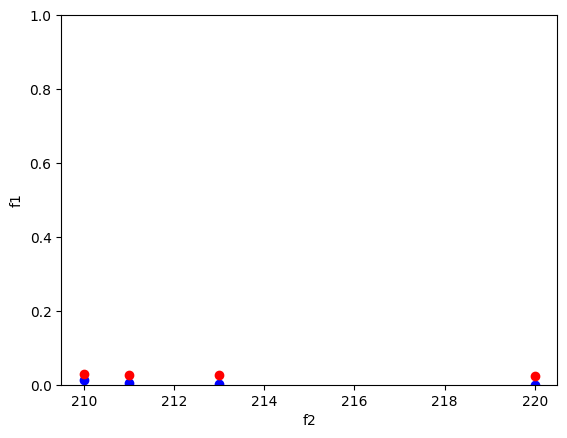

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on 3Obj-segment0...


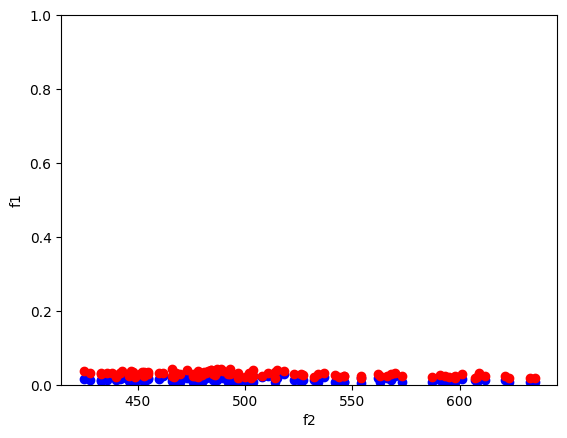

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on 2Obj-vehicle0...


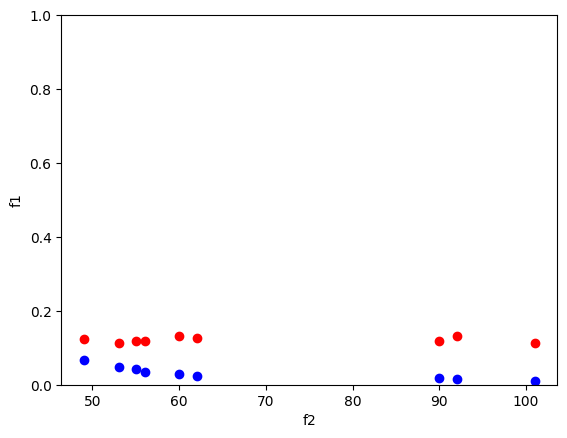

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on 3Obj-vehicle0...


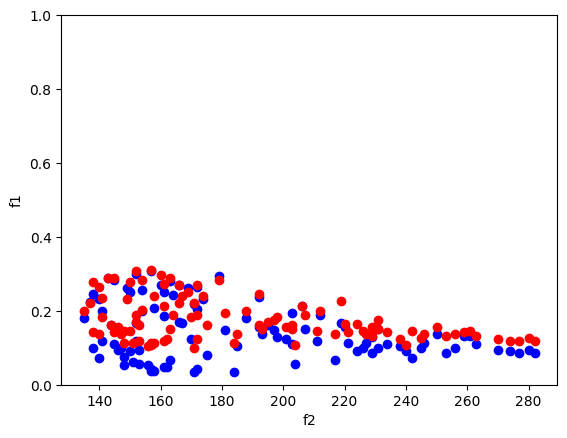

Executing <class '__main__.InstanceSelectionProblem_2_Obj'> on 2Obj-yeast1...


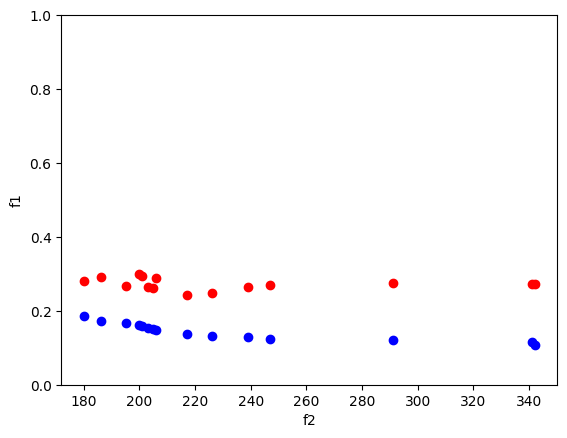

Executing <class '__main__.InstanceSelectionProblem_3_Obj'> on 3Obj-yeast1...


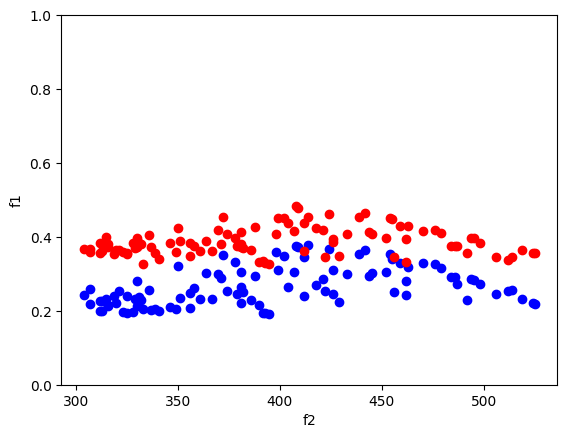

In [14]:
report_columns = ["Dataset",  "# Feature", "# Example", "# Training Examples","Optimized # Examples", "Baseline Acc %", "Optimized Acc %", "IR of entire dataset", "Best solution IR"]
results = []
for X, y, X_train, X_val, X_test, y_train, y_val, y_test, name in datasets:
	result = execute(X, y, X_train, X_val, X_test, y_train, y_val, y_test, f"2Obj-{name}", InstanceSelectionProblem_2_Obj)
	results.append(result)
	result = execute(X, y, X_train, X_val, X_test, y_train, y_val, y_test, f"3Obj-{name}", InstanceSelectionProblem_3_Obj)
	results.append(result)
    

In [15]:
report_columns = ["Dataset",  "# Feature", "# Example", "# Training Examples","Optimized # Examples", "Baseline Acc %", "Optimized Acc %", "IR of entire dataset", "Best solution IR"]
pd.DataFrame(results, columns=report_columns)

,Dataset,# Feature,# Example,# Training Examples,Optimized # Examples,Baseline Acc %,Optimized Acc %,IR of entire dataset,Best solution IR
0,2Obj-glass1,9,214,145,26.0,70.37,59.26,1.8158,1.1667
1,3Obj-glass1,9,214,145,41.0,70.37,62.96,1.8158,1.7333
2,2Obj-page-blocks0,10,5472,3016,914.0,96.93,96.42,8.7889,4.3450
3,3Obj-page-blocks0,10,5472,3016,1156.0,96.93,95.76,8.7889,2.8152
4,2Obj-pima,8,768,518,98.0,69.79,67.71,1.8657,1.3902
5,3Obj-pima,8,768,518,154.0,69.79,70.83,1.8657,1.8000
6,2Obj-segment0,19,2308,1319,220.0,98.61,97.75,6.0152,2.6667
7,3Obj-segment0,19,2308,1319,497.0,98.61,98.27,6.0152,1.7459
8,2Obj-vehicle0,18,846,523,101.0,92.92,88.68,3.2513,1.5897
9,3Obj-vehicle0,18,846,523,171.0,92.92,90.09,3.2513,1.0118
